# Tuning a `multi_match` `most_fields` query

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, evaluate_mrr100_dev_templated, optimize_query_mrr100, optimize_query_mrr100_templated
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://34.78.38.243:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

index = 'msmarco-document.doc2query'
template_id = 'query'
query_type = 'most_fields'

# set best BM25 params
set_bm25_params(es, index, [
    ('url', {'k1': 0.2835389588290694, 'b': 0.8307098387153782}),
    ('title', {'k1': 0.3477150744985997, 'b': 0.6174817900867441}),
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}),
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}),
    ('body.bigrams', {'k1': 1.9241932055770454, 'b': 0.7257382745572979}),
    ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}),
    ('expansions.bigrams', {'k1': 1.2, 'b': 0.75})
])

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

## Experiments

### Base fields

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2828
CPU times: user 1.84 s, sys: 479 ms, total: 2.32 s
Wall time: 2min 38s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:27 (remains: 0:22:45)
   | 0.2734 (best: 0.2734) - {'url|boost': 1.807445130405302, 'title|boost': 2.674705203246985, 'body|boost': 7.680740579719389}
 > iteration 2/50, took 0:00:16 (remains: 0:13:23)
   | 0.2546 (best: 0.2734) - {'url|boost': 7.0605371245785005, 'title|boost': 6.0984576752485795, 'body|boost': 4.131814044429558}
 > iteration 3/50, took 0:00:18 (remains: 0:14:45)
   | 0.2658 (best: 0.2734) - {'url|boost': 1.872951667802625, 'title|boost': 6.792791139129925, 'body|boost': 6.259852595648122}
 > iteration 4/50, took 0:00:09 (remains: 0:07:30)
   | 0.2179 (best: 0.2734) - {'url|boost': 2.9102178371272474, 'title|boost': 0.8528013375773548, 'body|boost': 0.04401123852850631}
 > iteration 5/50, took 0:00:18 (remains: 0:14:02)
   | 0.2659 (best: 0.2734) - {'url|boost': 3.881410638096062, 

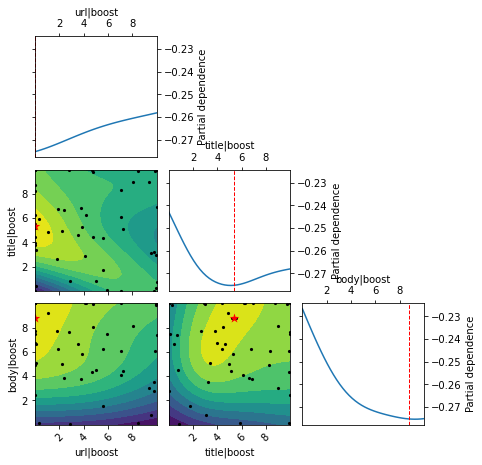

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [30]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100


RequestError: RequestError(400, 'number_format_exception', 'empty String')

In [31]:
final_params

{'url|boost': 3.519758620456686,
 'title|boost': 0.398314419893191,
 'body|boost': 6.402398225960093,
 'expansions|boost': 9.815369002074343}

### Base fields + bigrams

In [11]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2677
CPU times: user 1.81 s, sys: 511 ms, total: 2.32 s
Wall time: 5min 19s


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:01 (remains: 0:50:14)
   | 0.2252 (best: 0.2252) - {'url|boost': 5.630378001204965, 'title|boost': 2.7193389713650578, 'title_bigrams|boost': 5.867076461454305, 'body|boost': 1.2170425556929456, 'body_bigrams|boost': 4.185615522260307}
 > iteration 2/50, took 0:01:08 (remains: 0:54:30)
   | 0.2542 (best: 0.2542) - {'url|boost': 5.850058468711742, 'title|boost': 4.690451413826217, 'title_bigrams|boost': 3.3326343300840726, 'body|boost': 7.493303359901859, 'body_bigrams|boost': 7.353452251560913}
 > iteration 3/50, took 0:01:06 (remains: 0:51:57)
   | 0.1930 (best: 0.2542) - {'url|boost': 4.676040766421162, 'title|boost': 4.038037368800306, 'title_bigrams|boost': 9.870175739654726, 'body|boost': 1.955002355741267, 'body_bigrams|boost': 0.5148145039421038}
 > iteration 4/50, took 0:01:10 (remains: 0:53

/Users/josh/Documents/source/elastic/examples/Machine Learning/Query Optimization/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


 > iteration 32/50, took 0:01:12 (remains: 0:21:45)
   | 0.2680 (best: 0.2725) - {'url|boost': 0.0, 'title|boost': 10.0, 'title_bigrams|boost': 0.0, 'body|boost': 10.0, 'body_bigrams|boost': 0.0}
 > iteration 33/50, took 0:01:12 (remains: 0:20:24)
   | 0.2627 (best: 0.2725) - {'url|boost': 10.0, 'title|boost': 6.0307674596752605, 'title_bigrams|boost': 0.0, 'body|boost': 10.0, 'body_bigrams|boost': 3.008501031342351}
 > iteration 34/50, took 0:01:12 (remains: 0:19:24)
   | 0.2663 (best: 0.2725) - {'url|boost': 0.0, 'title|boost': 6.081883879552292, 'title_bigrams|boost': 3.0997322581193254, 'body|boost': 10.0, 'body_bigrams|boost': 4.480004617377428}
 > iteration 35/50, took 0:01:11 (remains: 0:17:47)
   | 0.2394 (best: 0.2725) - {'url|boost': 1.6437538493600614, 'title|boost': 9.69184590279165, 'title_bigrams|boost': 0.38360520021203276, 'body|boost': 0.04770952134034668, 'body_bigrams|boost': 9.053580442992091}
 > iteration 36/50, took 0:01:12 (remains: 0:16:48)
   | 0.2672 (best: 0.

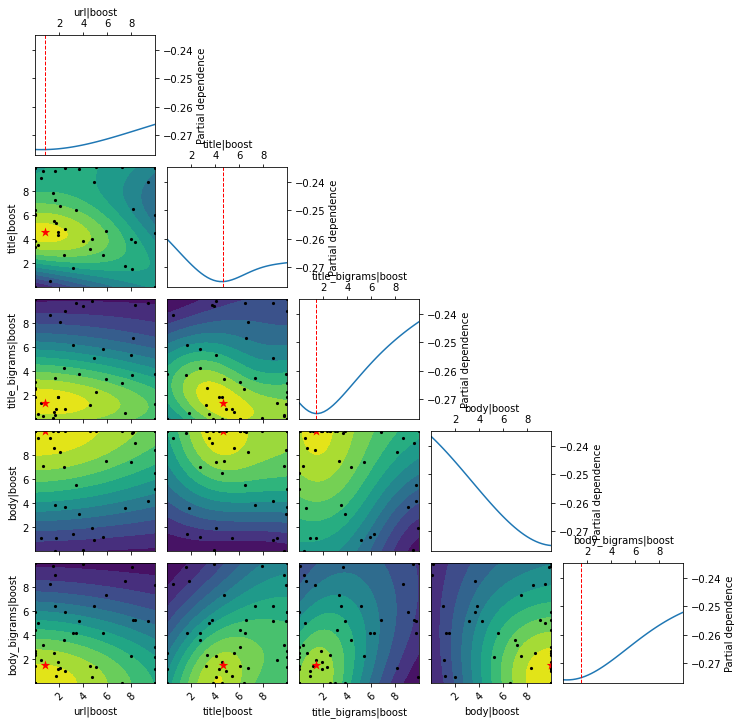

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2999
CPU times: user 1.76 s, sys: 459 ms, total: 2.22 s
Wall time: 5min 28s


In [16]:
final_params

{'url|boost': 0.8283370304984818,
 'title|boost': 4.6421846252468315,
 'title_bigrams|boost': 1.3767048290170831,
 'body|boost': 10.0,
 'body_bigrams|boost': 1.4996155110385425}

### Base fields + expansions

In [17]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
    ]
}

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3236
CPU times: user 2.89 s, sys: 656 ms, total: 3.55 s
Wall time: 2min 54s


In [19]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:31 (remains: 0:25:35)
   | 0.2958 (best: 0.2958) - {'url|boost': 9.169969976371409, 'title|boost': 9.927674742148136, 'body|boost': 9.126462834992324, 'expansions|boost': 7.721522797577334}
 > iteration 2/50, took 0:00:24 (remains: 0:19:25)
   | 0.2776 (best: 0.2958) - {'url|boost': 6.041234900009949, 'title|boost': 9.087125087303097, 'body|boost': 3.467205239221171, 'expansions|boost': 2.9914732541641116}
 > iteration 3/50, took 0:00:25 (remains: 0:20:09)
   | 0.2723 (best: 0.2958) - {'url|boost': 1.2445306727953767, 'title|boost': 6.005727257121344, 'body|boost': 4.413341583230514, 'expansions|boost': 0.4524760333690859}
 > iteration 4/50, took 0:00:23 (remains: 0:17:39)
   | 0.3008 (best: 0.3008) - {'url|boost': 8.05447955786363, 'title|boost': 6.15018266781703, 'body|boost': 3.2933729849605737, 

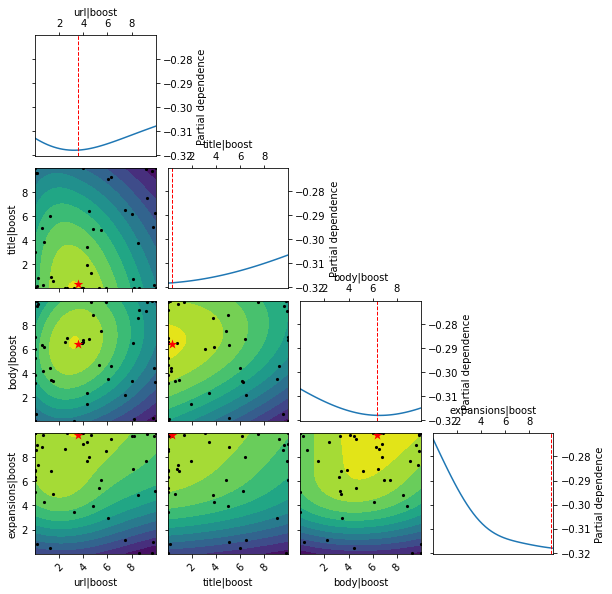

In [20]:
_ = plot_objective(metadata, sample_source='result')

In [21]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3363
CPU times: user 2.33 s, sys: 637 ms, total: 2.97 s
Wall time: 2min 37s


In [22]:
final_params

{'url|boost': 3.519758620456686,
 'title|boost': 0.398314419893191,
 'body|boost': 6.402398225960093,
 'expansions|boost': 9.815369002074343}

### Base fields + expansions + bigrams

In [23]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [24]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3204
CPU times: user 3.1 s, sys: 877 ms, total: 3.98 s
Wall time: 7min 4s


In [25]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/100, took 0:01:24 (remains: 2:19:03)
   | 0.3053 (best: 0.3053) - {'url|boost': 9.178075606316774, 'title|boost': 1.9301353192844233, 'title_bigrams|boost': 1.7082843600259836, 'body|boost': 1.7191095624242505, 'body_bigrams|boost': 0.8475965280072429, 'expansions|boost': 7.061356743160442, 'expansions_bigrams|boost': 5.6046813447222235}
 > iteration 2/100, took 0:01:22 (remains: 2:14:38)
   | 0.2642 (best: 0.3053) - {'url|boost': 1.5334833180472975, 'title|boost': 8.167237619432038, 'title_bigrams|boost': 3.309703110307372, 'body|boost': 2.328334686281017, 'body_bigrams|boost': 1.994401067091434, 'expansions|boost': 0.07052149500727857, 'expansions_bigrams|boost': 3.255669714703189}
 > iteration 3/100, took 0:01:24 (remains: 2:15:57)
   | 0.2861 (best: 0.3053) - {'url|boost': 6.343291397844057, 'title|boost': 1.

KeyboardInterrupt: 

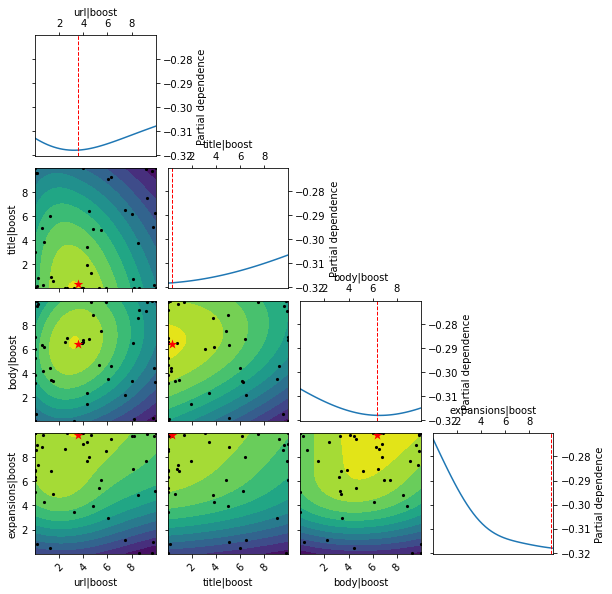

In [26]:
_ = plot_objective(metadata, sample_source='result')

In [27]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100


RequestError: RequestError(400, 'number_format_exception', 'empty String')

In [28]:
final_params

{'url|boost': 3.519758620456686,
 'title|boost': 0.398314419893191,
 'body|boost': 6.402398225960093,
 'expansions|boost': 9.815369002074343}

In [29]:
# with 100/20 iterations
# 0.3416

{
    'url|boost': 5.019618907965658,
    'title|boost': 2.1715172653248564,
    'title_bigrams|boost': 0.6258343432390224,
    'body|boost': 8.97005088495938,
    'body_bigrams|boost': 0.785011613141371,
    'expansions|boost': 9.958043226768973,
    'expansions_bigrams|boost': 2.6104666149721205
}

{'url|boost': 5.019618907965658,
 'title|boost': 2.1715172653248564,
 'title_bigrams|boost': 0.6258343432390224,
 'body|boost': 8.97005088495938,
 'body_bigrams|boost': 0.785011613141371,
 'expansions|boost': 9.958043226768973,
 'expansions_bigrams|boost': 2.6104666149721205}